# Frequency spectrum
This simple example calculates the brightness temperatures for an instrument looking at 52 degree with vertical and horizontal polarization at the top of the atmosphere (or satellite) and the ones for a zenith looking instrument at ground for the frequency range 10 to 200 GHz with 1 GHz resolution, all over ocean with no hydrometeors. Only passive simulations are performed. 

In [1]:
from __future__ import division # defines natural divisions like 1./2. = 1/2 = 0.5 and not 1/2 = 0
import pyPamtra  # import pyPamtra
import matplotlib.pyplot as plt  # import ploting modules
import numpy as np # import numpy for arrays, numerical array operations, ....
%matplotlib inline

Create a pyPamtra object

In [2]:
pam = pyPamtra.pyPamtra()

Define five hydrometeors as they are in the input profile. Defining hydrometeors is a mandatory step for PAMTRA simulations.

Here the scattering properties are selected as disabled, since we want to ignore them and perform clear sky simulations. Another option to accomplish this would be to set pam.p['hydro_q'] everywhere to zero.

In [3]:
descriptorFile = np.array([
        #['hydro_name' 'as_ratio' 'liq_ice' 'rho_ms' 'a_ms' 'b_ms' 'alpha_as' 'beta_as' 'moment_in' 'nbin' 'dist_name' 'p_1' 'p_2' 'p_3' 'p_4' 'd_1' 'd_2' 'scat_name' 'vel_size_mod' 'canting']
        ('cwc_q', -99.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 3, 1, 'mono', -99.0, -99.0,   2.0,    1.0,   2.0e-6,   8.0e-5, 'disabled', 'khvorostyanov01_drops', -99.0),
        ('iwc_q', 1.0, -1, 700.0, -99.0,  -99.0,  -99.0,   -99.0, 3, 1, 'mono', -99.0, -99.0, 1.564, 0.8547, 1.744e-5, 9.369e-3, 'disabled',   'heymsfield10_particles',  -99.0),
        ('rwc_q', -99.0, 1, -99.0, -99.0, -99.0,  -99.0, -99.0, 3, 50, 'exp', 0.22, 2.2,   -99.0,    -99.0,  0.00012,   0.006, 'disabled', 'khvorostyanov01_drops',  -99.0),
        ('swc_q', 1.0, -1, -99.0, 0.069, 2.0, 0.3971,  1.88, 3, 50, 'exp', 2.0e06, 0.,  -99.0, -99.0, 2.0e-04,  0.02, 'disabled',   'heymsfield10_particles', -99.0),
        ('gwc_q', -99.,-1, -99.0, 169.6, 3.1, -99.0, -99.0, 3, 50, 'exp', -99.0, -99.0, 4.0e6, -99.0, 1.0e-10, 1.0e-2, 'disabled', 'khvorostyanov01_spheres', -99.0)],
        dtype=[('hydro_name', 'S15'), ('as_ratio', '<f8'), ('liq_ice', '<i8'), ('rho_ms', '<f8'), ('a_ms', '<f8'), ('b_ms', '<f8'), ('alpha_as', '<f8'), ('beta_as', '<f8'), ('moment_in', '<i8'), ('nbin', '<i8'), ('dist_name', 'S15'), ('p_1', '<f8'), ('p_2', '<f8'), ('p_3', '<f8'), ('p_4', '<f8'), ('d_1', '<f8'), ('d_2', '<f8'), ('scat_name', 'S20'), ('vel_size_mod', 'S30'), ('canting', '<f8')] 
        )

Add hydrometeors to the pam.df object.

In [4]:
for hyd in descriptorFile: pam.df.addHydrometeor(hyd)

Read single profile from ascii file into PAMTRA object. The somehow outdated option to read ascii input files, can still be used. This might be especially handy when using the pure FORTRAN version of PAMTRA.

In [5]:
pam.readPamtraProfile('/home/mech/workspace/pamtra/profile/single_ocean.lay')

Plot atmospheric profiles.

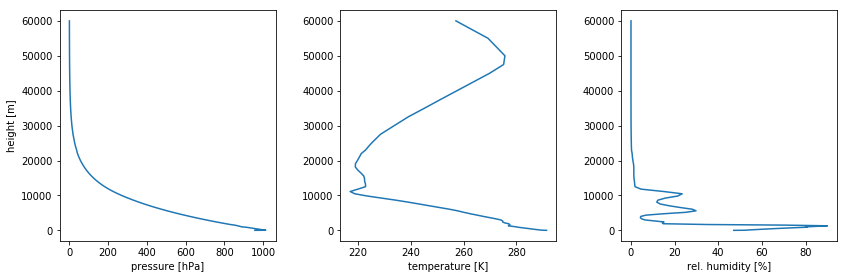

In [6]:
fig = plt.figure(figsize=[12,4])
fig.add_axes([0.1,0.1,0.25,0.8])
plt.plot(pam.p['press'][0,0,:]/100.,pam.p['hgt'][0,0,:])
plt.ylabel('height [m]')
plt.xlabel('pressure [hPa]')
fig.add_axes([0.425,0.1,0.25,0.8])
plt.plot(pam.p['temp'][0,0,:],pam.p['hgt'][0,0,:])
plt.xlabel('temperature [K]')
fig.add_axes([0.75,0.1,0.25,0.8])
plt.plot(pam.p['relhum'][0,0,:],pam.p['hgt'][0,0,:])
plt.xlabel('rel. humidity [%]')
plt.show()

Define frequency grid

In [7]:
freqs = np.arange(10.,200.,1.)

Deactivate active simulations.

In [8]:
pam.nmlSet['active'] = False

Run PAMTRA in parallel mode by using all local workers (cores of cpu). Parallelization is done in frequency dimension.

In [9]:
pam.runParallelPamtra(freqs, pp_deltaX=1, pp_deltaY=1, pp_deltaF=10, pp_local_workers="auto")

The results of the PAMTRA simulation are stored in pam.r. Here we look at the brightness temperature, namely pam.r['tb'].

The dimensions of this object can be seen by:

In [15]:
pam.dimensions['tb']

['gridx', 'gridy', 'outlevels', 'angles', 'frequency', 'passive_npol']

gridx = 1<br>
gridy = 1<br>
outlevels = 2 (from top to bottom)<br>
angles = 32 (0 = nadir, 31 = zenith)<br>
frequency = 190<br>
passive_pol = 2 (V,H)

Plot the resulting brightness temperatures against the frequency.

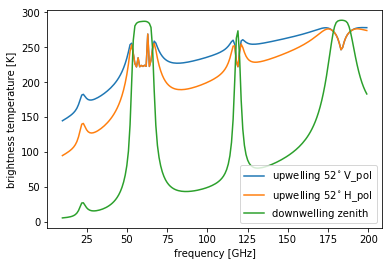

In [12]:
plt.figure()
plt.plot(freqs,pam.r["tb"][0,0,0,7,:,0],label='upwelling 52$^{\circ}$ V_pol')
plt.plot(freqs,pam.r["tb"][0,0,0,7,:,1],label='upwelling 52$^{\circ}$ H_pol')
plt.plot(freqs,pam.r["tb"][0,0,1,31,:].mean(axis=-1),label='downwelling zenith')
plt.xlabel('frequency [GHz]')
plt.ylabel('brightness temperature [K]')
plt.legend(loc=4)
plt.show()